# Bartosz Jabłoński

# Projekt Zaliczeniowy - Temat 2

Przewidywanie wzięcia pożyczki. Celem projektu jest zastosowanie modeli klasyfikacji (binarnej) do
przewidzenia czy pożyczka zostanie udzielona danemu klientowi z danymi parametrami wniosku.

### Link do danych:
https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv
### Opis danych (najdokładniejszy jaki istnieje):
https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802


## Zmienna celu (wypłacenie pożyczki): Disbursed

#### Wymogi:
<ul> 
<li> Zmienna LoggedIn nie może być uwzględniona w modelowaniu - należy ją od razu wyrzucić ze zbioru. </li>
<li> Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.</li>
<li> Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięci logarytmu ze zmiennej tym, że rozkład jest skośny).</li>
<li> Należy wykorzystać przynajmniej 3 metody klasyfikacji.</li>
<li> Należy uwzględnić optymalizację modeli/pipelinów.</li>
<li>Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań (modeli/pipelinów) w postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.</li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import datetime
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, scale, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import accuracy_score, roc_curve, f1_score, roc_auc_score, classification_report
from xgboost.sklearn import XGBClassifier
from scipy.stats import norm
from scipy import stats
from sklearn.svm import SVC


In [2]:
pd.set_option('display.max_columns', 30) # -> wyświetla maks liczbę kolumn 
pd.set_option('float_format', '{:.2f}'.format) # -> floaty - zaokrąglenie do 2mc po przecinku

In [3]:
#Otworzenie pliku
data = pd.read_csv('https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv', encoding='latin1')
#encoding pozwala na usunięcie UnicodeDecodeError, który pojawia się przy zwykłym otworzeniu pliku

In [4]:
data

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.00,5.00,0.00,CYBOSOL,HDFC Bank,N,0,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.00,2.00,0.00,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.00,2.00,13.25,nan,6762.90,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.00,4.00,0.00,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.00,4.00,nan,nan,nan,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.00,5.00,0.00,BIHAR GOVERNMENT,State Bank of India,Y,10,HBXX,920000.00,5.00,nan,nan,nan,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.00,2.00,25000.00,GLOBAL EDGE SOFTWARE,HDFC Bank,Y,17,HBXX,500000.00,2.00,nan,nan,nan,N,Web-browser,B,S134,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,ID124813N30,Female,Ajmer,71901,27-Nov-69,31-Jul-15,1000000.00,5.00,14500.00,MAYO COLLEGE,ICICI Bank,N,9,HBXX,nan,nan,nan,nan,nan,N,Web-browser,G,S122,3,0,0
87016,ID124814O40,Female,Kochi,16000,01-Dec-90,31-Jul-15,0.00,0.00,0.00,KERALA COMMUNICATORS CABLE LTD,Federal Bank,Y,1,HBXB,240000.00,4.00,35.50,4800.00,9425.76,Y,Mobile,G,S122,5,0,0
87017,ID124816Q10,Male,Bengaluru,118000,28-Jan-72,31-Jul-15,0.00,0.00,0.00,BANGALORE INSTITUTE OF TECHNOLOGY,Syndicate Bank,Y,8,HBXX,1200000.00,4.00,nan,nan,nan,N,Mobile,G,S122,3,0,0
87018,ID124818S30,Male,Bengaluru,98930,27-Apr-77,31-Jul-15,800000.00,5.00,13660.00,FIRSTSOURCE SOLUTION LTD,ICICI Bank,Y,18,HBXX,800000.00,5.00,nan,nan,nan,N,Web-browser,G,S122,3,0,0


In [5]:
# Usunięcie kolumny LoggedIn (wynika z treści projektu)
data = data.drop(['LoggedIn'], axis=1)

Podział na zbiór treningowy i testowy

In [6]:
X = data.drop(['Disbursed'], axis=1)
y = data.Disbursed
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.22) 

### Weryfikacja kolumn

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67875 entries, 50709 to 3086
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     67875 non-null  object 
 1   Gender                 67875 non-null  object 
 2   City                   67079 non-null  object 
 3   Monthly_Income         67875 non-null  int64  
 4   DOB                    67875 non-null  object 
 5   Lead_Creation_Date     67875 non-null  object 
 6   Loan_Amount_Applied    67819 non-null  float64
 7   Loan_Tenure_Applied    67819 non-null  float64
 8   Existing_EMI           67819 non-null  float64
 9   Employer_Name          67819 non-null  object 
 10  Salary_Account         58638 non-null  object 
 11  Mobile_Verified        67875 non-null  object 
 12  Var5                   67875 non-null  int64  
 13  Var1                   67875 non-null  object 
 14  Loan_Amount_Submitted  40874 non-null  float64
 15 

In [8]:
# Stworzenie funkcji, która pozwoli na weryfikację liczby NaN,
# wartości unikalnych (umożliwia zastosowanie odpowiednich transformacji)
# oraz wartości unikalnych (łatwe przejrzenie różnych wartości)

def description(df: pd.DataFrame) -> pd.DataFrame:
    df = X_train
    df_size = df.shape[0]
    column_types = [df[column].dtype for column in df.columns]
    NaN_amount = [df[column].isna().sum(axis=0) for column in df.columns]
    unique_values_amount = [np.unique(df[column].astype(str)).size for column in df.columns]
    unique_values = [np.unique(df[column].astype(str)) for column in df.columns]
    df_describe = pd.DataFrame({
        'Nazwa': df.columns, 
        'Typ Kolumny': column_types, 
        'Liczba NaN': NaN_amount,
        'Ilość wartości unikalnych': unique_values_amount,
        'Wartości Unikalne': unique_values})
    
    return(df_describe.sort_values(by='Ilość wartości unikalnych', ascending=False))

In [9]:
#Uruchomienie powyższej funkcji
description(X_train)

,Nazwa,Typ Kolumny,Liczba NaN,Ilość wartości unikalnych,Wartości Unikalne
0,ID,object,0,67875,"[ID000002C20, ID000004E40, ID000007H20, ID0000..."
9,Employer_Name,object,56,35877,"[ , , , ADLER MEDIEQUIP PVT LTD, RAJ..."
4,DOB,object,0,10698,"[01-Apr-57, 01-Apr-60, 01-Apr-61, 01-Apr-62, 0..."
3,Monthly_Income,int64,0,4976,"[0, 1, 10, 100, 1000, 10000, 100000, 1000000, ..."
18,EMI_Loan_Submitted,float64,46179,4075,"[10003.12, 10008.95, 10009.0, 10009.82, 10011...."
8,Existing_EMI,float64,56,3174,"[0.0, 1.0, 1.5, 10.0, 100.0, 1000.0, 10000.0, ..."
2,City,object,796,676,"[ADIPUR, AHMEDB, AMALSAD, ANJAR, Abohar, Adila..."
17,Processing_Fee,float64,46413,548,"[1000.0, 10000.0, 10050.0, 10100.0, 10125.0, 1..."
6,Loan_Amount_Applied,float64,56,251,"[0.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, ..."
14,Loan_Amount_Submitted,float64,27001,195,"[100000.0, 1000000.0, 1010000.0, 1020000.0, 10..."


In [10]:
df = X_train

### Zmienne kategoryczne

In [11]:
# Stworzenie funkcji, która odpowiada za zamianę zmiennych kompletnych kategorycznych o niewielkiej liczbie parametrów na zmienne liczbowe
def transformacja_tr(df):
    df["Gender"] =  df.Gender.map({"Male":0, "Female":1})
    df["Filled_Form"] =  df.Filled_Form.map({"N":0, "Y":1})
    df["Device_Type"] =  df.Device_Type.map({"Mobile":0, "Web-browser":1})
    df["Mobile_Verified"] =  df.Mobile_Verified.map({"N":0, "Y":1})
    df["Var2"] =  df.Var2.map({"A":0, "B":1, "C":2, "D":3, "E":4, "F":5, "G":6})

In [12]:
# Uruchomienie powyższej funkcji 
transformacja_tr(df)

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [13]:
df

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
50709,ID072754G40,0,Tirunelveli,52000,12-Jul-84,27-Jun-15,300000.00,5.00,19000.00,NUCLEAR POWER CORPORATION OF INDIA LTD,State Bank of India,1,9,HAVC,300000.00,5.00,16.00,6000.00,7295.42,0,1,1,S143,4
58445,ID083858I30,0,Varanasi,19600,07-May-85,04-Jul-15,0.00,0.00,0.00,KASHI GOMTI SAMYUT GRAMIN BANK,NaN,1,1,HBXB,310000.00,4.00,33.00,6200.00,11709.19,1,0,6,S122,5
11814,ID016834M40,0,Hyderabad,44000,23-Mar-83,14-May-15,300000.00,4.00,3000.00,DHANALAKSHMI ENGINEETRING & FABRICATION,Bank of India,1,14,HAXB,350000.00,4.00,14.85,7000.00,9714.17,1,1,1,S122,5
67284,ID096585V00,0,Kolkata,26000,17-Jan-77,14-Jul-15,0.00,0.00,0.00,FLAT PRODUCTS,State Bank of India,1,3,HBXX,470000.00,4.00,nan,nan,nan,0,0,6,S122,3
71958,ID103308K30,0,Hyderabad,40000,06-Jun-85,18-Jul-15,0.00,0.00,0.00,COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,HDFC Bank,1,8,HBXX,710000.00,4.00,nan,nan,nan,0,0,6,S122,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51791,ID074290I00,1,Delhi,30000,27-Sep-90,28-Jun-15,0.00,0.00,0.00,PRIME TECH SOLUTIONS,HDFC Bank,1,3,HBXD,460000.00,4.00,19.00,10350.00,13754.05,1,0,2,S122,5
8385,ID011908A30,0,Delhi,50000,23-Apr-84,11-May-15,0.00,0.00,0.00,0,NaN,1,14,HAXB,820000.00,5.00,14.85,16400.00,19443.24,1,1,3,S122,5
30425,ID043606E10,1,Thiruvananthapuram,80000,19-May-69,04-Jun-15,3000000.00,0.00,0.00,AZEER,NaN,0,12,HBXX,nan,nan,nan,nan,nan,0,1,1,S133,3
9773,ID013869L40,0,Delhi,35000,18-Feb-90,12-May-15,0.00,0.00,0.00,DELL CALL CENTRE,ICICI Bank,1,4,HBXX,540000.00,5.00,nan,nan,nan,0,0,2,S133,3


#### Zmienna Var1

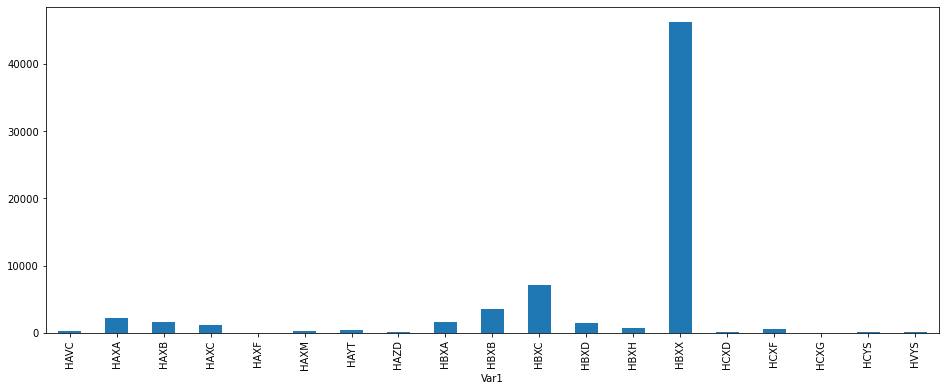

In [14]:
plt.subplots(figsize=(16,6))
a = df.groupby(['Var1'])['Var1'].count()
a.plot(kind='bar')
plt.show()

In [15]:
df.Var1.value_counts()

HBXX    46179
HBXC     7068
HBXB     3498
HAXA     2293
HBXA     1645
HAXB     1601
HBXD     1543
HAXC     1190
HBXH      749
HCXF      542
HAYT      399
HAVC      299
HAXM      216
HCXD      188
HCYS      173
HVYS      144
HAZD       79
HCXG       59
HAXF       10
Name: Var1, dtype: int64

nie ma braków, Maks liczba: 67875, zmienna HBXX odpowiada za prawię połowę obserwacji (68,17%), a pierwsze pięć za prawie 90% (89%) obserwacji zasadnym jest, żeby wziąc rozdzielić pierwszych 5 obserwacji, natomiast, pozostałe potraktować jako inne.

In [16]:
def dictMap(main, non_main):
    mapped_dict = {}
    for i, main in enumerate(reversed(main)):
        mapped_dict[main] = (i+1)
    mapped_dict[non_main] = 0
    return mapped_dict

In [18]:
#Żeby funkcja zadziałała należy ją puścić dwukrotnie - nie wiem dlaczego
Var1_counts = df.Var1.value_counts()
main_Var1 = list(Var1_counts.index[:5])
df.loc[ ~df['Var1'].isin(main_Var1), 'Var1' ] = 'non-main Var1'
mapped_Var1 = dictMap(main_Var1, 'Non-main Var1')
df['Var1'] = df['Var1'].map( mapped_Var1 ).astype(int)

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Zmienna Source

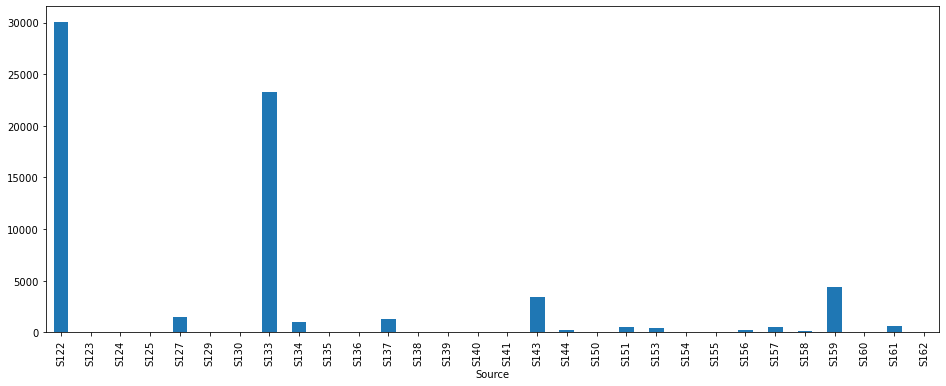

In [19]:
plt.subplots(figsize=(16,6))
c = df.groupby(['Source'])['Source'].count()
c.plot(kind='bar')
plt.show()

In [20]:
df.Source.value_counts()

S122    30071
S133    23283
S159     4362
S143     3424
S127     1509
S137     1318
S134     1017
S161      600
S151      557
S157      514
S153      398
S156      250
S144      230
S158      167
S123       52
S141       44
S162       31
S124       17
S160        9
S150        4
S136        3
S155        3
S129        2
S135        2
S139        2
S138        2
S130        1
S140        1
S125        1
S154        1
Name: Source, dtype: int64

Z uwagi na to, że poza pierwszym znakiem, zmienna ma wartości numeryczne, wygodniej jest po prostu usunąć pierwszy znak literowy i zamienić zmienną na liczbową. Dodatkowo, nie wiadomo jaki wpływ ma na zmienną celu oraz czy nie istnieją inne zmienne, które są z nią sprzężone, więc taka metoda wydaje się być bezpieczniejszą.

In [21]:
# Zamiana zmiennej Source
df.Source = df.Source.apply(lambda x: x[1:]).astype(int)

d:\programy\python 3.7.0\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Zmienna Salary_Account

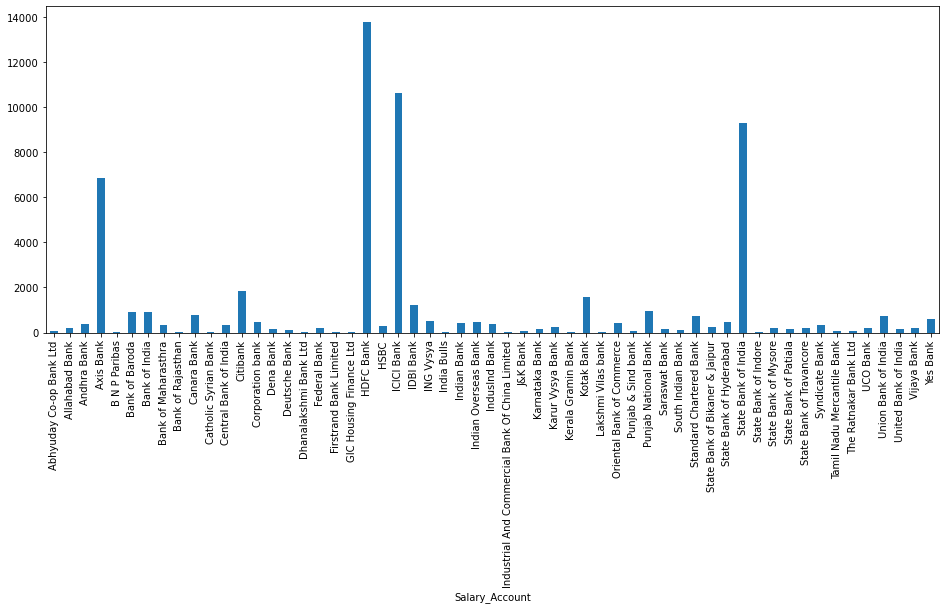

In [22]:
plt.subplots(figsize=(16,6))
c = df.groupby(['Salary_Account'])['Salary_Account'].count()
c.plot(kind='bar')
plt.show()

In [23]:
df.Salary_Account.value_counts()

HDFC Bank                                          13769
ICICI Bank                                         10613
State Bank of India                                 9292
Axis Bank                                           6856
Citibank                                            1850
Kotak Bank                                          1575
IDBI Bank                                           1200
Punjab National Bank                                 939
Bank of India                                        904
Bank of Baroda                                       893
Canara Bank                                          798
Union Bank of India                                  745
Standard Chartered Bank                              741
Yes Bank                                             615
ING Vysya                                            525
Corporation bank                                     488
Indian Overseas Bank                                 480
State Bank of Hyderabad        

Z uwagi na to, że jest 58 unikalnych wartości, wezmę 20 najpopularniejszych kont, natomiast reszta zostanie potraktowana jako inna

In [24]:
def dictMap(listOfMajors, non_major):
    mapped_dict = {}
    for i, major in enumerate(reversed(listOfMajors)):
        mapped_dict[major] = (i+1)
    mapped_dict[non_major] = 0
    return mapped_dict
bank_counts = df.Salary_Account.value_counts()
major_banks = list(bank_counts.index[:20])
df.loc[ ~df['Salary_Account'].isin(major_banks), 'Salary_Account' ] = 'Non-major bank'
mapped_banks = dictMap(major_banks, 'Non-major bank')
df['Salary_Account'] = df['Salary_Account'].map( mapped_banks ).astype(int)

d:\programy\python 3.7.0\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


#### Zmienna City

Zmienna City, z uwagi na to ,że już na początku widać różne wielkości liter w nazwach miast - sprowadzę je do jednej postaci, wszystkie nazwy będą pisane dużymi literami.

In [25]:
df.City = df.City.astype(str)
df.City = df.City.apply(lambda x: x.upper()).astype(str)

d:\programy\python 3.7.0\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
df.City.value_counts()

DELHI         9769
BENGALURU     8418
MUMBAI        8396
HYDERABAD     5607
CHENNAI       5423
              ... 
SEONI            1
KUPWARA          1
AMBIKAPUR        1
CHITRAKOOT       1
RAMPUR           1
Name: City, Length: 676, dtype: int64

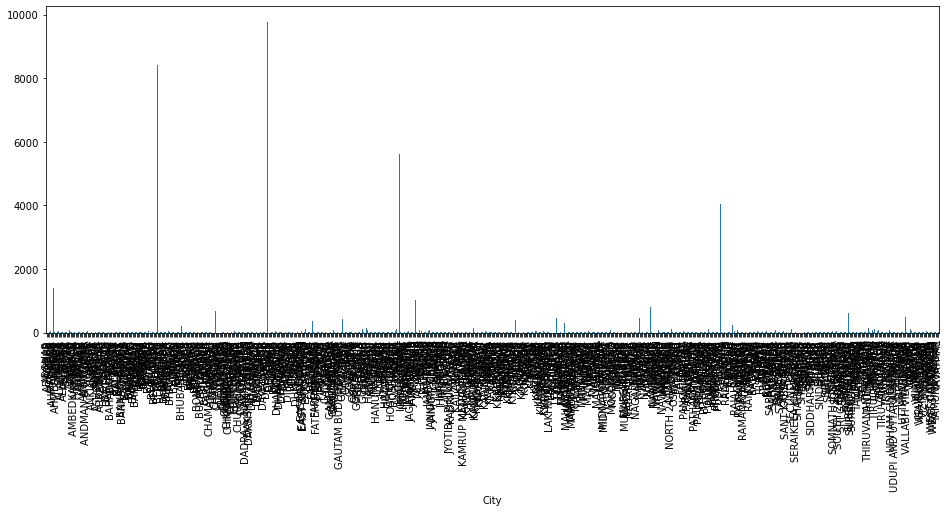

In [27]:
plt.subplots(figsize=(16,6))
d = df.groupby(['City'])['City'].count()
d.plot(kind='bar')
plt.show()

Występuje ogromna liczba miast, dlatego jak w przypadku powyżej, wykorzystam tylko 30 najpopularniejszych, natomiast pozsotałe pozostaną potraktowane jako inne. Wydaje się to być sensowne, biorąc pod uwagę fakt, że populacja Indii to ponad 1 miliard mieszkańców, a za Wikipedią w pierwszej 30 miast znajdują się te, które mają powyżej 1,2 miliona  [mieszkańców](https://pl.wikipedia.org/wiki/Miasta_w_Indiach#Najwi%C4%99ksze_miasta_w_Indiach).

In [28]:
def dictMap(listOfMajors, non_major):
    mapped_dict = {}
    for i, major in enumerate(reversed(listOfMajors)):
        mapped_dict[major] = (i+1)
    mapped_dict[non_major] = 0
    return mapped_dict

cities_counts = df.City.value_counts()
major_cities = list(cities_counts.index[:30])
df.loc[ ~df['City'].isin(major_cities), 'City' ] = 'Non-major city'
mapped_cities = dictMap(major_cities, 'Non-major city')
df['City'] = df['City'].map( mapped_cities ).astype(int)

d:\programy\python 3.7.0\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


#### Zmienna Employer_Name

Employer name - ta sama operacja co w przypadku zmiennej City

In [29]:
df.Employer_Name = df.Employer_Name.astype(str)
df.Employer_Name = df.Employer_Name.apply(lambda x: x.upper()).astype(str)

d:\programy\python 3.7.0\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [30]:
en = df.Employer_Name.value_counts()
en.head(30)

0                                               3900
TATA CONSULTANCY SERVICES LTD (TCS)              423
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD     321
ACCENTURE SERVICES PVT LTD                       255
GOOGLE                                           242
HCL TECHNOLOGIES LTD                             201
ICICI BANK LTD                                   185
INDIAN AIR FORCE                                 142
GENPACT                                          140
INDIAN ARMY                                      137
INFOSYS TECHNOLOGIES                             128
IBM CORPORATION                                  128
TYPE SLOWLY FOR AUTO FILL                        127
WIPRO TECHNOLOGIES                               118
IKYA HUMAN CAPITAL SOLUTIONS LTD                 108
HDFC BANK LTD                                    107
INDIAN RAILWAY                                   105
STATE GOVERNMENT                                 105
INDIAN NAVY                                   

Z uwagi na bardzo dużą ilośc wartości unikatowych a jednocześnie występowanie group kapitałowych (np. IBM corporation i IBM Global Services India, Indian airforce, Indian Army i Indina Navy). Biorąc pod uwagę ew. potencjał istotności tej zmiennej oraz czas i koszt oczyszczenia, pogrupowania i prezentacji tej zmiennej zdecydowałem się ją usunąć.

In [31]:
df = df.drop('Employer_Name', axis =1)

#### Zamiana daty

In [32]:
from datetime import date
from datetime import datetime
import datetime as DT
import io

# Z uwgai na to, że przy zwykłej zamianie daty, python część zmiennych traktuje jako rok 2000, 
# zdecydowałem się na rozdzielenie dni, miesięcy i lat.
def fixDates(data):
    df['DOB_yr'] = [item.split('-')[2] for item in df['DOB']]
    df.DOB_yr = '19' + df.DOB_yr
    df['DOB_mon'] = [item.split('-')[1] for item in df['DOB']]
    df['DOB_day'] = [item.split('-')[0] for item in df['DOB']]
    df.DOB = df.apply(lambda x: pd.datetime.strptime("{0} {1} {2} 00:00:00".format(x['DOB_yr'],x['DOB_mon'], x['DOB_day']), "%Y %b %d %H:%M:%S"),axis=1)

In [33]:
# użcyie funkcji a następnie usunięcie meisięcy i dni jako nieistotnych
fixDates(df)
df.drop( [ 'DOB_mon', 'DOB_day' ] , axis=1, inplace=True)
df.DOB_yr = [int(x) for x in df.DOB_yr]

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


In [34]:
# Kolumna LEAD_Creation_Date zawiera daty w 2015, w związku z tym, użyje roku 2015 jako bazy, a następnie wyrzucę zmienną jako nieistotną przy modelowaniu.
YEAR = 2015
df['Age'] = YEAR - df.DOB_yr

In [35]:
df.drop( [ 'DOB', 'Lead_Creation_Date', 'DOB_yr' ],axis=1, inplace=True)

In [36]:
df

,ID,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
50709,ID072754G40,0,0,52000,300000.00,5.00,19000.00,18,1,9,4,300000.00,5.00,16.00,6000.00,7295.42,0,1,1,143,4,31
58445,ID083858I30,0,0,19600,0.00,0.00,0.00,0,1,1,2,310000.00,4.00,33.00,6200.00,11709.19,1,0,6,122,5,30
11814,ID016834M40,0,27,44000,300000.00,4.00,3000.00,12,1,14,4,350000.00,4.00,14.85,7000.00,9714.17,1,1,1,122,5,32
67284,ID096585V00,0,24,26000,0.00,0.00,0.00,18,1,3,5,470000.00,4.00,nan,nan,nan,0,0,6,122,3,38
71958,ID103308K30,0,27,40000,0.00,0.00,0.00,20,1,8,5,710000.00,4.00,nan,nan,nan,0,0,6,122,3,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51791,ID074290I00,1,30,30000,0.00,0.00,0.00,20,1,3,4,460000.00,4.00,19.00,10350.00,13754.05,1,0,2,122,5,25
8385,ID011908A30,0,30,50000,0.00,0.00,0.00,0,1,14,4,820000.00,5.00,14.85,16400.00,19443.24,1,1,3,122,5,31
30425,ID043606E10,1,0,80000,3000000.00,0.00,0.00,0,0,12,5,nan,nan,nan,nan,nan,0,1,1,133,3,46
9773,ID013869L40,0,30,35000,0.00,0.00,0.00,19,1,4,5,540000.00,5.00,nan,nan,nan,0,0,2,133,3,25


### Zmienne numeryczne

Kolumny (oryginalnie) numeryczne, dla których sprawdzę za pomocą wykresów rozkłady tych kolumn

In [37]:
numeryczne = ['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 
                     'Var5', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 
                     'Processing_Fee', 'EMI_Loan_Submitted', 'Var4']

In [38]:
#Stworzenie dataframe'u dla zmiennych numerycznych
df_num = df[['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 
                     'Var5', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 
                     'Processing_Fee', 'EMI_Loan_Submitted', 'Var4']].copy()
df_num

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4
50709,52000,300000.00,5.00,19000.00,9,300000.00,5.00,16.00,6000.00,7295.42,4
58445,19600,0.00,0.00,0.00,1,310000.00,4.00,33.00,6200.00,11709.19,5
11814,44000,300000.00,4.00,3000.00,14,350000.00,4.00,14.85,7000.00,9714.17,5
67284,26000,0.00,0.00,0.00,3,470000.00,4.00,nan,nan,nan,3
71958,40000,0.00,0.00,0.00,8,710000.00,4.00,nan,nan,nan,3
...,...,...,...,...,...,...,...,...,...,...,...
51791,30000,0.00,0.00,0.00,3,460000.00,4.00,19.00,10350.00,13754.05,5
8385,50000,0.00,0.00,0.00,14,820000.00,5.00,14.85,16400.00,19443.24,5
30425,80000,3000000.00,0.00,0.00,12,nan,nan,nan,nan,nan,3
9773,35000,0.00,0.00,0.00,4,540000.00,5.00,nan,nan,nan,3


In [39]:
df_num.describe()

,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Var5,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Var4
count,67875.00,67819.00,67819.00,67819.00,67875.00,40874.00,40874.00,21696.00,21462.00,21696.00,67875.00
mean,61638.79,229911.53,2.13,3721.52,4.96,395194.99,3.89,19.18,5144.10,11018.85,2.95
std,2425997.13,354002.42,2.01,44799.05,5.67,308526.86,1.17,5.83,4742.68,7477.90,1.70
min,0.00,0.00,0.00,0.00,0.00,50000.00,1.00,11.99,200.00,1176.41,0.00
25%,16500.00,0.00,0.00,0.00,0.00,200000.00,3.00,15.00,2000.00,6494.36,1.00
50%,25000.00,100000.00,2.00,0.00,2.00,300000.00,4.00,18.00,4000.00,9433.41,3.00
75%,40000.00,300000.00,4.00,3500.00,11.00,500000.00,5.00,20.00,6250.00,12970.28,5.00
max,444554443.00,10000000.00,10.00,10000000.00,18.00,3000000.00,6.00,37.00,50000.00,135564.48,7.00


In [40]:
df_num.skew().sort_values()

Loan_Tenure_Submitted    -0.84
Var4                      0.22
Loan_Tenure_Applied       0.27
Var5                      0.76
Interest_Rate             1.44
Loan_Amount_Submitted     2.10
EMI_Loan_Submitted        2.62
Processing_Fee            2.67
Loan_Amount_Applied       5.54
Monthly_Income          154.21
Existing_EMI            190.51
dtype: float64

Wyznaczenie skośności rozkładu.
<ul>
<li> Współczynnik o wartości 0 to rozkład symetryczny. 
<li> Współczynnik o wartości ujemnej to rozkład lewostronnie skośny (wydłużone lewe ramię rozkładu; średnia mniejsza od mediany).
<li> Współczynnik o wartości dodatniej to rozkład prawostronnie skośny (wydłużone prawe ramię rozkładu; średniej większa od mediany).
   </li>
    </ul>
Najbardziej symetryczne rozkłądy mają zmienne 'Loan_Tenure_Submitted', 'Var4', 'Loan_Tenure_Applied', 'Var5' oraz  'Interest_Rate'.
 

In [41]:
df_num.kurtosis().abs().sort_values()

Loan_Tenure_Submitted       0.25
Var4                        0.87
Var5                        0.99
Interest_Rate               1.16
Loan_Tenure_Applied         1.44
Loan_Amount_Submitted       6.39
Processing_Fee             10.42
EMI_Loan_Submitted         14.55
Loan_Amount_Applied        67.46
Monthly_Income          26052.40
Existing_EMI            39786.60
dtype: float64

Wyznaczenie Kurtozy (spłaszczenia rozkładu) Zmiennych numerycznych. Kurtoza mówi o tym, jak bardzo względem rozkładu normalnego jest rozkład danej zmiennej jest spłaszczony (ujemne wartości kurtozy) lub wydęty (dodatnie wartości kurtozy). 
<ul> 
    </ul>
    Jak widać wszystkie zmienne są "wydęte". Najbliżej rozkładu normalnego są zmienne 'Loan_Tenure_Submitted', Var4, Var5, Interest_Rate oraz Loan_Tenure_Applied.

In [42]:
df_num.agg(['kurtosis',
            'skew']).T.rename(columns = {"kurtosis" : "Spłaszczenie",
                                         'skew' : 'Skośność'}).sort_values(by = 'Skośność', ascending = True)

,Spłaszczenie,Skośność
Loan_Tenure_Submitted,-0.25,-0.84
Var4,-0.87,0.22
Loan_Tenure_Applied,-1.44,0.27
Var5,-0.99,0.76
Interest_Rate,1.16,1.44
Loan_Amount_Submitted,6.39,2.10
EMI_Loan_Submitted,14.55,2.62
Processing_Fee,10.42,2.67
Loan_Amount_Applied,67.46,5.54
Monthly_Income,26052.40,154.21


Jak widać na obecną chwilę najbliżej rozkładowi normalnemu odpowiadają zmienne:
<ul>
<li> Loan_Tenure_Applied
<li> Var5
<li> Loan_Tenure_Submitted
<li> Interest_Rate	
<li> Var4
    </li>
    </ul>
    
W związku z tym ew. braki dla Loan_Tenure_Submitted zostaną uzupełnione średnią a dla pozostałych zmiennych medianą. Dzięki temu rozkłady powinny zbliżyć się jeszcze bardziej do rozkładu normalnego

In [43]:
df["Loan_Tenure_Submitted"] = df.Loan_Tenure_Submitted.fillna(df.Loan_Tenure_Submitted.mean())
df["Loan_Tenure_Applied"] = df.Loan_Tenure_Applied.fillna(df.Loan_Tenure_Applied.median())
df["Var5"] = df.Var5.fillna(df.Var5.median())
df["Var4"] = df.Var4.fillna(df.Var4.median())
df["Interest_Rate"] = df.Interest_Rate.fillna(df.Interest_Rate.median())

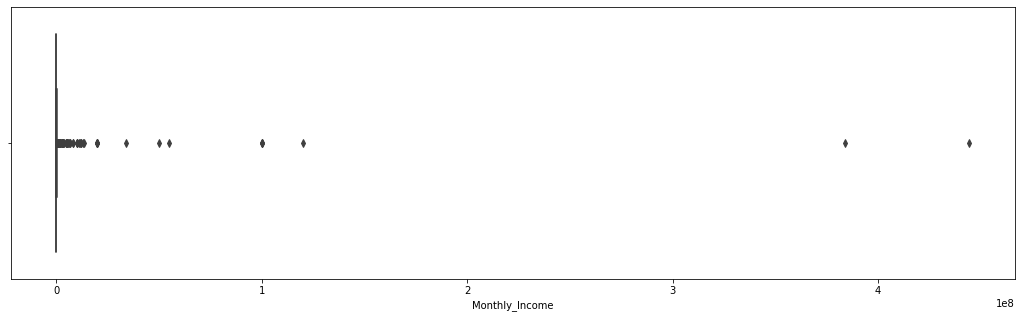

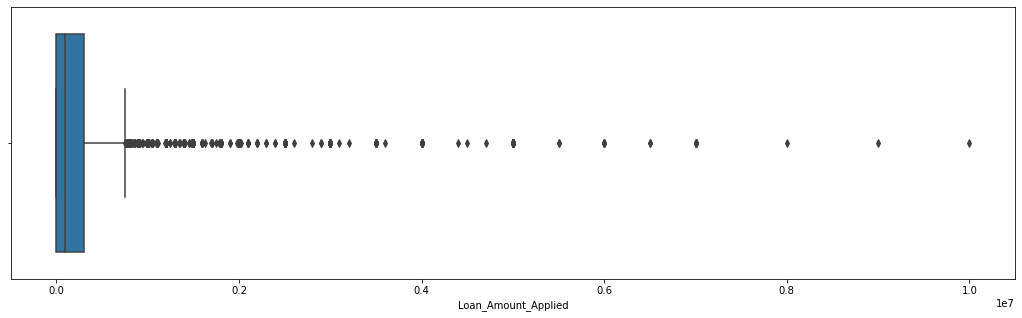

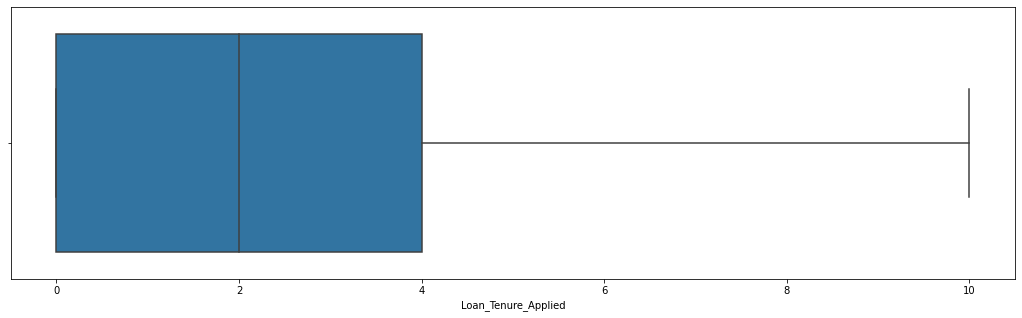

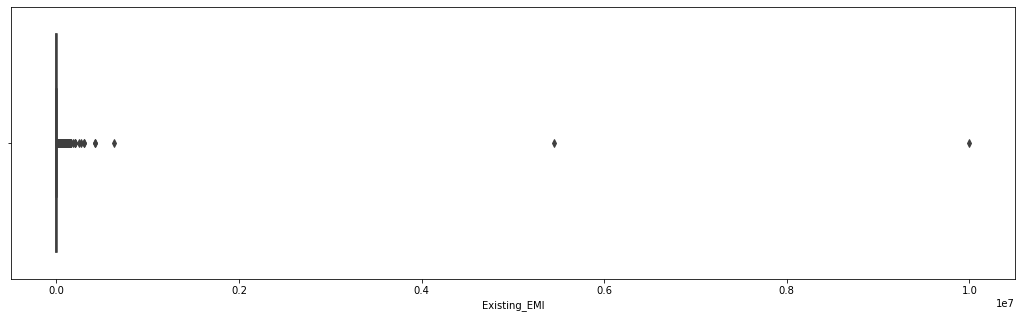

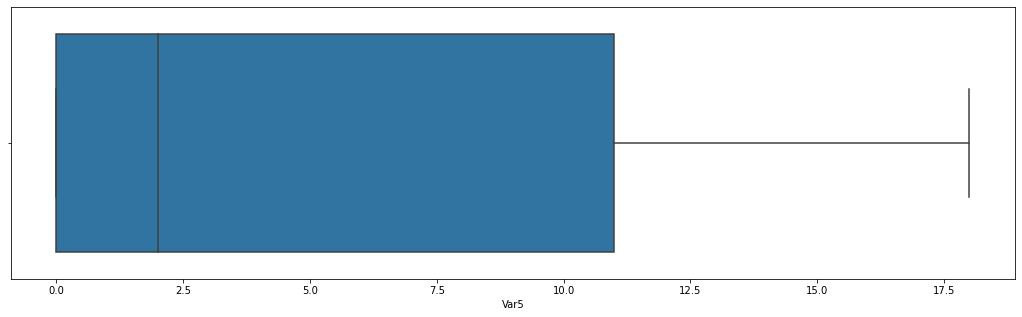

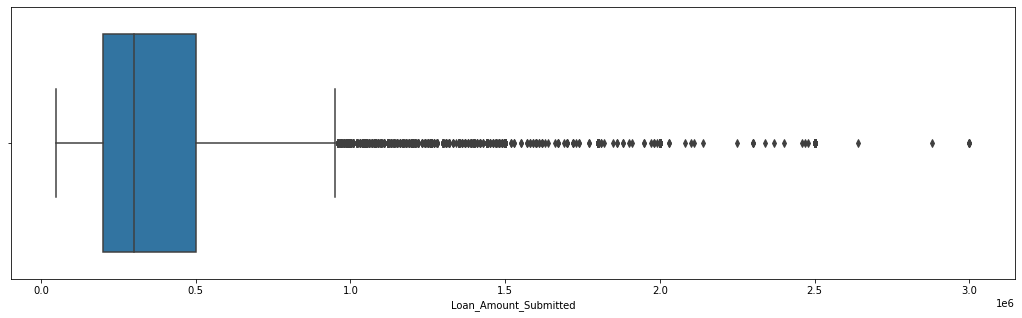

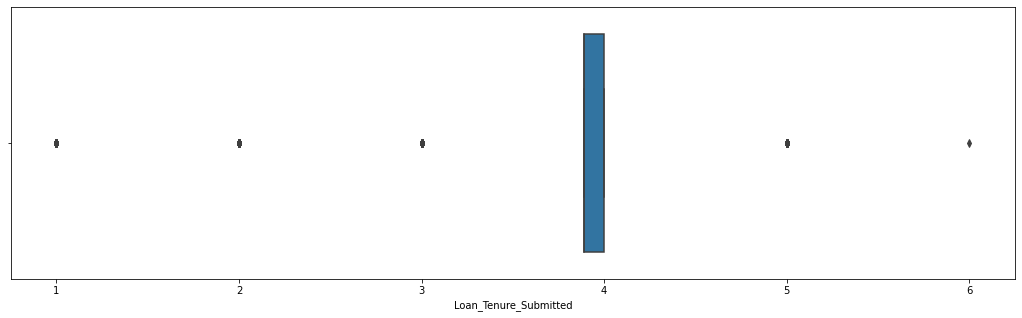

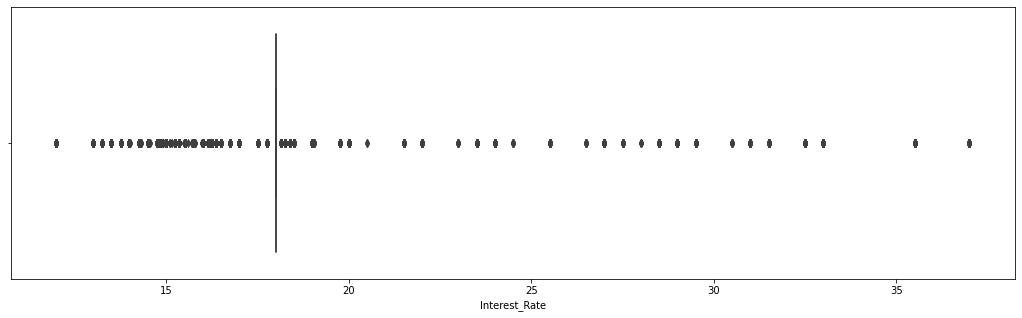

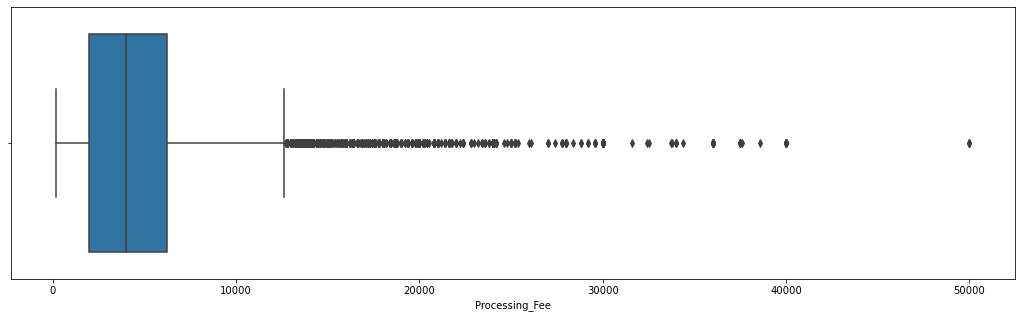

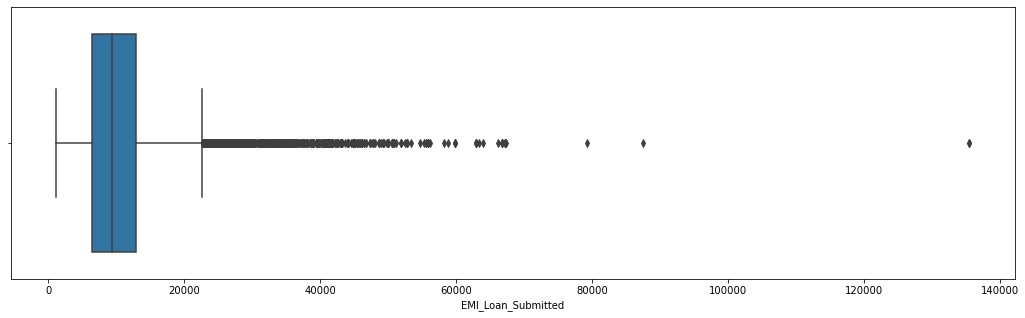

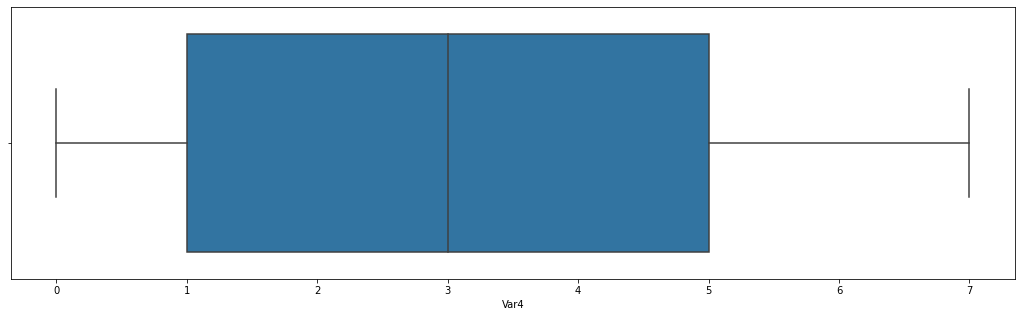

In [44]:
# sprawdzenie wartości kolumn numerycznych na wykresach pudełkowych (Q1, Q3, ew. wartości odstające)
for col in numeryczne:
    fig, ax = plt.subplots(figsize=(18,5))
    sns.boxplot(df[col])
    plt.show()

Jak widać kolumny Monthly_Income, Loan_Amount_Applied, Existing_EMI, Loan_Amount_Submitted, Processing_Fee oraz EMI_Loan_Submitted posiadają bardzo dużo wartości odstających. Należy je w jakiś sposób zmodyfikować.

In [45]:
df.head()

,ID,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
50709,ID072754G40,0,0,52000,300000.00,5.00,19000.00,18,1,9,4,300000.00,5.00,16.00,6000.00,7295.42,0,1,1,143,4,31
58445,ID083858I30,0,0,19600,0.00,0.00,0.00,0,1,1,2,310000.00,4.00,33.00,6200.00,11709.19,1,0,6,122,5,30
11814,ID016834M40,0,27,44000,300000.00,4.00,3000.00,12,1,14,4,350000.00,4.00,14.85,7000.00,9714.17,1,1,1,122,5,32
67284,ID096585V00,0,24,26000,0.00,0.00,0.00,18,1,3,5,470000.00,4.00,18.00,nan,nan,0,0,6,122,3,38
71958,ID103308K30,0,27,40000,0.00,0.00,0.00,20,1,8,5,710000.00,4.00,18.00,nan,nan,0,0,6,122,3,30


In [46]:
df = df.drop(["ID"], axis  = 1 )

In [47]:
# Wypisanie rozkładów ćwiartkowych
Odstające = ['Monthly_Income',
             'Loan_Amount_Applied',
             'Existing_EMI', 
             'Loan_Amount_Submitted',
             'Processing_Fee','EMI_Loan_Submitted']

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR[Odstające]

Monthly_Income           23500.00
Loan_Amount_Applied     300000.00
Existing_EMI              3500.00
Loan_Amount_Submitted   300000.00
Processing_Fee            4250.00
EMI_Loan_Submitted        6475.92
dtype: float64

In [48]:
# Wypisanie podstawowy statystyk (minima, maksima, wartości brzeżne (lewe i prawe) oraz odchylenia standardowe)
minimum = np.min(df)
maksimum = np.max(df)
lewy = Q1 - 1.5 * IQR 
prawy = Q3 + 1.5 * IQR
σ = np.std(X_train)

In [49]:
# Przedstawienie statystyk w jednym miejscu
pd.DataFrame({'Q1': Q1[Odstające], 'Q3': Q3[Odstające], 'IQR': IQR[Odstające], 
              'minimum': minimum[Odstające], 'maksimum': maksimum[Odstające], 'σ': σ[Odstające], 
              'Lewy brzeg': lewy[Odstające], 'Prawy brzeg': prawy[Odstające]})

,Q1,Q3,IQR,minimum,maksimum,σ,Lewy brzeg,Prawy brzeg
Monthly_Income,16500.00,40000.00,23500.00,0.00,444554443.00,2425979.26,-18750.00,75250.00
Loan_Amount_Applied,0.00,300000.00,300000.00,0.00,10000000.00,353999.81,-450000.00,750000.00
Existing_EMI,0.00,3500.00,3500.00,0.00,10000000.00,44798.72,-5250.00,8750.00
Loan_Amount_Submitted,200000.00,500000.00,300000.00,50000.00,3000000.00,308523.09,-250000.00,950000.00
Processing_Fee,2000.00,6250.00,4250.00,200.00,50000.00,4742.56,-4375.00,12625.00
EMI_Loan_Submitted,6494.36,12970.28,6475.92,1176.41,135564.48,7477.72,-3219.52,22684.16


Wniosek:
<ul>
 </ul>
<li>Zmienne dla lewego zakresu nie mogą być ujemne, w związku z tym muszą przyjmować wartości równe 0.
<li> Należy wystandaryzować prawy brzeg ograniczając wartości odstajace do prawego brzegu - stworzyć granice "normalności", które zostaną przyjęte dla zmiennych odstających

In [50]:
# Standaryzacja prawego brzegu
prawy_MI = prawy['Monthly_Income']
prawy_LAA = prawy['Loan_Amount_Applied']
prawy_ExEMI = prawy['Existing_EMI']
prawy_LAS = prawy['Loan_Amount_Submitted']
prawy_PF = prawy['Processing_Fee']
prawy_EMIS = prawy['EMI_Loan_Submitted']

In [51]:
def Standaryzacja_numerycznych(df: pd.DataFrame) -> pd.DataFrame:
    df.Monthly_Income = df.Monthly_Income.apply(lambda x:0 if x==np.nan else x if x < prawy_MI else prawy_MI)
    df.Loan_Amount_Applied = df.Loan_Amount_Applied.apply(lambda x: 0 if x == np.nan else x if x < prawy_LAA else prawy_LAA)
    df.Existing_EMI = df.Existing_EMI.apply(lambda x: 0 if x == np.nan else x if x < prawy_ExEMI else prawy_ExEMI)
    df.Loan_Amount_Submitted = df.Loan_Amount_Submitted.apply(lambda x:0 if x==np.nan else x if x < prawy_LAS else prawy_LAS)
    df.Processing_Fee = df.Processing_Fee.apply(lambda x:0 if x==np.nan else x if x < prawy_PF else prawy_PF)
    df.EMI_Loan_Submitted = df.EMI_Loan_Submitted.apply(lambda x:0 if x==np.nan else x if x < prawy_EMIS else prawy_EMIS)
    
    return df

In [52]:
Standaryzacja_numerycznych(df)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
50709,0,0,52000.00,300000.00,5.00,8750.00,18,1,9,4,300000.00,5.00,16.00,6000.00,7295.42,0,1,1,143,4,31
58445,0,0,19600.00,0.00,0.00,0.00,0,1,1,2,310000.00,4.00,33.00,6200.00,11709.19,1,0,6,122,5,30
11814,0,27,44000.00,300000.00,4.00,3000.00,12,1,14,4,350000.00,4.00,14.85,7000.00,9714.17,1,1,1,122,5,32
67284,0,24,26000.00,0.00,0.00,0.00,18,1,3,5,470000.00,4.00,18.00,12625.00,22684.16,0,0,6,122,3,38
71958,0,27,40000.00,0.00,0.00,0.00,20,1,8,5,710000.00,4.00,18.00,12625.00,22684.16,0,0,6,122,3,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51791,1,30,30000.00,0.00,0.00,0.00,20,1,3,4,460000.00,4.00,19.00,10350.00,13754.05,1,0,2,122,5,25
8385,0,30,50000.00,0.00,0.00,0.00,0,1,14,4,820000.00,5.00,14.85,12625.00,19443.24,1,1,3,122,5,31
30425,1,0,75250.00,750000.00,0.00,0.00,0,0,12,5,950000.00,3.89,18.00,12625.00,22684.16,0,1,1,133,3,46
9773,0,30,35000.00,0.00,0.00,0.00,19,1,4,5,540000.00,5.00,18.00,12625.00,22684.16,0,0,2,133,3,25


In [53]:
X_train = df

In [54]:
X_train

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
50709,0,0,52000.00,300000.00,5.00,8750.00,18,1,9,4,300000.00,5.00,16.00,6000.00,7295.42,0,1,1,143,4,31
58445,0,0,19600.00,0.00,0.00,0.00,0,1,1,2,310000.00,4.00,33.00,6200.00,11709.19,1,0,6,122,5,30
11814,0,27,44000.00,300000.00,4.00,3000.00,12,1,14,4,350000.00,4.00,14.85,7000.00,9714.17,1,1,1,122,5,32
67284,0,24,26000.00,0.00,0.00,0.00,18,1,3,5,470000.00,4.00,18.00,12625.00,22684.16,0,0,6,122,3,38
71958,0,27,40000.00,0.00,0.00,0.00,20,1,8,5,710000.00,4.00,18.00,12625.00,22684.16,0,0,6,122,3,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51791,1,30,30000.00,0.00,0.00,0.00,20,1,3,4,460000.00,4.00,19.00,10350.00,13754.05,1,0,2,122,5,25
8385,0,30,50000.00,0.00,0.00,0.00,0,1,14,4,820000.00,5.00,14.85,12625.00,19443.24,1,1,3,122,5,31
30425,1,0,75250.00,750000.00,0.00,0.00,0,0,12,5,950000.00,3.89,18.00,12625.00,22684.16,0,1,1,133,3,46
9773,0,30,35000.00,0.00,0.00,0.00,19,1,4,5,540000.00,5.00,18.00,12625.00,22684.16,0,0,2,133,3,25


### Weryfikacja procesu transformacji

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67875 entries, 50709 to 3086
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 67875 non-null  int64  
 1   City                   67875 non-null  int32  
 2   Monthly_Income         67875 non-null  float64
 3   Loan_Amount_Applied    67875 non-null  float64
 4   Loan_Tenure_Applied    67875 non-null  float64
 5   Existing_EMI           67875 non-null  float64
 6   Salary_Account         67875 non-null  int32  
 7   Mobile_Verified        67875 non-null  int64  
 8   Var5                   67875 non-null  int64  
 9   Var1                   67875 non-null  int32  
 10  Loan_Amount_Submitted  67875 non-null  float64
 11  Loan_Tenure_Submitted  67875 non-null  float64
 12  Interest_Rate          67875 non-null  float64
 13  Processing_Fee         67875 non-null  float64
 14  EMI_Loan_Submitted     67875 non-null  float64
 15 

In [56]:
description(X_train)

,Nazwa,Typ Kolumny,Liczba NaN,Ilość wartości unikalnych,Wartości Unikalne
2,Monthly_Income,float64,0,4503,"[0.0, 1.0, 10.0, 100.0, 1000.0, 10000.0, 10002..."
14,EMI_Loan_Submitted,float64,0,3419,"[10003.12, 10008.95, 10009.0, 10009.82, 10011...."
5,Existing_EMI,float64,0,1903,"[0.0, 1.0, 1.5, 10.0, 100.0, 1000.0, 1004.0, 1..."
13,Processing_Fee,float64,0,410,"[1000.0, 10000.0, 10050.0, 10100.0, 10125.0, 1..."
3,Loan_Amount_Applied,float64,0,174,"[0.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, ..."
10,Loan_Amount_Submitted,float64,0,91,"[100000.0, 110000.0, 120000.0, 130000.0, 14000..."
12,Interest_Rate,float64,0,73,"[11.99, 12.99, 13.0, 13.25, 13.49, 13.5, 13.75..."
20,Age,int64,0,60,"[100, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, ..."
1,City,int32,0,31,"[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,..."
18,Source,int32,0,30,"[122, 123, 124, 125, 127, 129, 130, 133, 134, ..."


##### Jak widać, wszystkie zmienne zostały zamienione, a ew. braki w jakiś sposób uzupełnione. W związku z tym można przystąpić do analogicznych operacji zamiany części testowej. 

### część testowa

In [57]:
transformacja_tr(X_test)

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

#### Var1

In [59]:
#Żeby funkcja zadziałała należy ją puścić dwukrotnie - nie wiem dlaczego (jak w części treningowej)
Var1_counts = X_test.Var1.value_counts()
main_Var1 = list(Var1_counts.index[:5])
X_test.loc[ ~X_test['Var1'].isin(main_Var1), 'Var1' ] = 'non-main Var1'
mapped_Var1 = dictMap(main_Var1, 'Non-main Var1')
X_test['Var1'] = X_test['Var1'].map( mapped_Var1 ).astype(int)

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Zmienna Source

In [60]:
X_test.Source = X_test.Source.apply(lambda x: x[1:]).astype(int)

d:\programy\python 3.7.0\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Zmienna Salary_Account

In [61]:
bank_counts = X_test.Salary_Account.value_counts()
major_banks = list(bank_counts.index[:20])
X_test.loc[ ~X_test['Salary_Account'].isin(major_banks), 'Salary_Account' ] = 'Non-major bank'
mapped_banks = dictMap(major_banks, 'Non-major bank')
X_test['Salary_Account'] = X_test['Salary_Account'].map( mapped_banks ).astype(int)

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Zmienna City

In [62]:
X_test.City = X_test.City.astype(str)
X_test.City = X_test.City.apply(lambda x: x.upper()).astype(str)

In [63]:
cities_counts = X_test.City.value_counts()
major_cities = list(cities_counts.index[:30])
X_test.loc[ ~X_test['City'].isin(major_cities), 'City' ] = 'Non-major city'
mapped_cities = dictMap(major_cities, 'Non-major city')
X_test['City'] = X_test['City'].map( mapped_cities ).astype(int)

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Zmienna Employer_Name

In [64]:
X_test = X_test.drop('Employer_Name', axis =1)

In [65]:
X_test

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
26238,ID037570A00,1,30,13500,06-Apr-88,30-May-15,300000.00,5.00,3000.00,20,0,0,5,nan,nan,nan,nan,nan,0,1,1,159,1
73913,ID106084E40,0,29,19000,15-Aug-88,21-Jul-15,200000.00,3.00,2800.00,20,1,2,2,200000.00,4.00,28.50,4000.00,7027.77,0,1,6,122,4
63321,ID090843Z30,1,27,16623,28-Jun-85,09-Jul-15,100000.00,2.00,0.00,14,1,1,5,100000.00,2.00,nan,nan,nan,0,1,6,122,3
77119,ID110584G40,0,11,30000,02-Jul-85,23-Jul-15,0.00,0.00,0.00,18,1,4,5,540000.00,4.00,nan,nan,nan,0,0,6,122,3
63923,ID091696U10,1,30,18000,08-Jul-85,09-Jul-15,300000.00,3.00,11000.00,18,0,0,5,nan,nan,nan,nan,nan,0,1,6,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75795,ID108766I10,1,30,13000,19-Apr-86,22-Jul-15,0.00,0.00,0.00,12,0,0,5,nan,nan,nan,nan,nan,0,0,6,122,1
43091,ID061751B10,1,21,12800,19-Aug-89,19-Jun-15,0.00,0.00,0.00,5,0,0,5,nan,nan,nan,nan,nan,0,0,2,159,1
15288,ID021837X20,0,27,37500,16-Mar-89,18-May-15,350000.00,4.00,0.00,19,1,11,4,350000.00,4.00,16.25,5250.00,9963.97,1,1,1,133,5
25296,ID036219B40,0,27,34080,30-Aug-89,29-May-15,0.00,0.00,0.00,8,1,5,5,400000.00,3.00,nan,nan,nan,0,0,2,159,3


### Data

In [66]:
def fixDates_test(df):
    X_test['DOB_yr'] = [item.split('-')[2] for item in X_test['DOB']]
    X_test.DOB_yr = '19' + X_test.DOB_yr
    X_test['DOB_mon'] = [item.split('-')[1] for item in X_test['DOB']]
    X_test['DOB_day'] = [item.split('-')[0] for item in X_test['DOB']]
    X_test.DOB = X_test.apply(lambda x: pd.datetime.strptime("{0} {1} {2} 00:00:00".format(x['DOB_yr'],x['DOB_mon'], x['DOB_day']), "%Y %b %d %H:%M:%S"),axis=1)

In [67]:
fixDates_test(X_test)

d:\programy\python 3.7.0\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [68]:
X_test.drop( [ 'DOB_mon', 'DOB_day' ] , axis=1, inplace=True)
X_test.DOB_yr = [int(x) for x in X_test.DOB_yr]

In [69]:
X_test['Age'] = YEAR - X_test.DOB_yr

In [70]:
X_test.drop( [ 'DOB', 'Lead_Creation_Date', 'DOB_yr' ],axis=1, inplace=True)

#### Zmienne numeryczne

In [71]:
X_test["Loan_Tenure_Submitted"] = X_test.Loan_Tenure_Submitted.fillna(X_test.Loan_Tenure_Submitted.mean())
X_test["Loan_Tenure_Applied"] = X_test.Loan_Tenure_Applied.fillna(X_test.Loan_Tenure_Applied.median())
X_test["Var5"] = X_test.Var5.fillna(X_test.Var5.median())
X_test["Var4"] = X_test.Var4.fillna(X_test.Var4.median())
X_test["Interest_Rate"] = X_test.Interest_Rate.fillna(X_test.Interest_Rate.median())

In [72]:
Standaryzacja_numerycznych(X_test)

,ID,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
26238,ID037570A00,1,30,13500.00,300000.00,5.00,3000.00,20,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,1,1,159,1,27
73913,ID106084E40,0,29,19000.00,200000.00,3.00,2800.00,20,1,2,2,200000.00,4.00,28.50,4000.00,7027.77,0,1,6,122,4,27
63321,ID090843Z30,1,27,16623.00,100000.00,2.00,0.00,14,1,1,5,100000.00,2.00,18.00,12625.00,22684.16,0,1,6,122,3,30
77119,ID110584G40,0,11,30000.00,0.00,0.00,0.00,18,1,4,5,540000.00,4.00,18.00,12625.00,22684.16,0,0,6,122,3,30
63923,ID091696U10,1,30,18000.00,300000.00,3.00,8750.00,18,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,1,6,122,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75795,ID108766I10,1,30,13000.00,0.00,0.00,0.00,12,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,0,6,122,1,29
43091,ID061751B10,1,21,12800.00,0.00,0.00,0.00,5,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,0,2,159,1,26
15288,ID021837X20,0,27,37500.00,350000.00,4.00,0.00,19,1,11,4,350000.00,4.00,16.25,5250.00,9963.97,1,1,1,133,5,26
25296,ID036219B40,0,27,34080.00,0.00,0.00,0.00,8,1,5,5,400000.00,3.00,18.00,12625.00,22684.16,0,0,2,159,3,26


In [73]:
X_test = X_test.drop(['ID'], axis = 1)

In [74]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19145 entries, 26238 to 39231
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 19145 non-null  int64  
 1   City                   19145 non-null  int32  
 2   Monthly_Income         19145 non-null  float64
 3   Loan_Amount_Applied    19145 non-null  float64
 4   Loan_Tenure_Applied    19145 non-null  float64
 5   Existing_EMI           19145 non-null  float64
 6   Salary_Account         19145 non-null  int32  
 7   Mobile_Verified        19145 non-null  int64  
 8   Var5                   19145 non-null  int64  
 9   Var1                   19145 non-null  int32  
 10  Loan_Amount_Submitted  19145 non-null  float64
 11  Loan_Tenure_Submitted  19145 non-null  float64
 12  Interest_Rate          19145 non-null  float64
 13  Processing_Fee         19145 non-null  float64
 14  EMI_Loan_Submitted     19145 non-null  float64
 15

In [75]:
description(X_test)

,Nazwa,Typ Kolumny,Liczba NaN,Ilość wartości unikalnych,Wartości Unikalne
2,Monthly_Income,float64,0,4503,"[0.0, 1.0, 10.0, 100.0, 1000.0, 10000.0, 10002..."
14,EMI_Loan_Submitted,float64,0,3419,"[10003.12, 10008.95, 10009.0, 10009.82, 10011...."
5,Existing_EMI,float64,0,1903,"[0.0, 1.0, 1.5, 10.0, 100.0, 1000.0, 1004.0, 1..."
13,Processing_Fee,float64,0,410,"[1000.0, 10000.0, 10050.0, 10100.0, 10125.0, 1..."
3,Loan_Amount_Applied,float64,0,174,"[0.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, ..."
10,Loan_Amount_Submitted,float64,0,91,"[100000.0, 110000.0, 120000.0, 130000.0, 14000..."
12,Interest_Rate,float64,0,73,"[11.99, 12.99, 13.0, 13.25, 13.49, 13.5, 13.75..."
20,Age,int64,0,60,"[100, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, ..."
1,City,int32,0,31,"[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,..."
18,Source,int32,0,30,"[122, 123, 124, 125, 127, 129, 130, 133, 134, ..."


In [76]:
X_test

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
26238,1,30,13500.00,300000.00,5.00,3000.00,20,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,1,1,159,1,27
73913,0,29,19000.00,200000.00,3.00,2800.00,20,1,2,2,200000.00,4.00,28.50,4000.00,7027.77,0,1,6,122,4,27
63321,1,27,16623.00,100000.00,2.00,0.00,14,1,1,5,100000.00,2.00,18.00,12625.00,22684.16,0,1,6,122,3,30
77119,0,11,30000.00,0.00,0.00,0.00,18,1,4,5,540000.00,4.00,18.00,12625.00,22684.16,0,0,6,122,3,30
63923,1,30,18000.00,300000.00,3.00,8750.00,18,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,1,6,122,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75795,1,30,13000.00,0.00,0.00,0.00,12,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,0,6,122,1,29
43091,1,21,12800.00,0.00,0.00,0.00,5,0,0,5,950000.00,3.90,18.00,12625.00,22684.16,0,0,2,159,1,26
15288,0,27,37500.00,350000.00,4.00,0.00,19,1,11,4,350000.00,4.00,16.25,5250.00,9963.97,1,1,1,133,5,26
25296,0,27,34080.00,0.00,0.00,0.00,8,1,5,5,400000.00,3.00,18.00,12625.00,22684.16,0,0,2,159,3,26


### Wizualizacja Korelacji

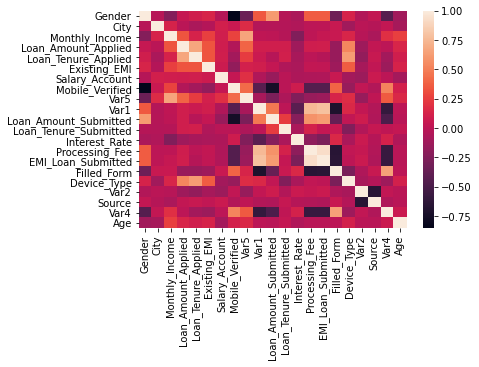

In [77]:
corr = X_train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [78]:
mapakorelacji = cmap=sns.diverging_palette(5, 250, as_cmap=True)

corr.style.background_gradient(mapakorelacji, axis=1).set_properties(**{'max-width': '8060px', 'font-size': '7pt'}).set_caption("Korelacja zmiennych po przekształceniach").set_precision(2)

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age
Gender,1.00,-0.01,-0.24,0.05,0.10,0.14,-0.03,-0.85,-0.34,0.35,0.62,-0.02,-0.07,0.37,0.37,-0.32,0.13,-0.04,0.03,-0.43,-0.11
City,-0.01,1.00,0.13,-0.00,-0.06,-0.03,0.11,0.06,0.17,-0.03,-0.02,-0.03,-0.04,0.00,0.01,0.05,-0.11,-0.01,-0.02,0.04,-0.09
Monthly_Income,-0.24,0.13,1.00,0.34,0.13,0.26,0.10,0.27,0.66,0.02,0.01,-0.02,-0.25,0.01,0.05,0.06,0.14,-0.01,-0.07,0.19,0.26
Loan_Amount_Applied,0.05,-0.00,0.34,1.00,0.67,0.34,0.09,-0.04,0.40,0.10,0.10,0.10,-0.11,0.09,0.10,-0.15,0.53,-0.13,0.03,0.01,0.14
Loan_Tenure_Applied,0.10,-0.06,0.13,0.67,1.00,0.34,0.10,-0.10,0.24,0.07,-0.02,0.11,-0.08,0.00,-0.02,-0.15,0.63,-0.17,0.06,-0.11,0.10
Existing_EMI,0.14,-0.03,0.26,0.34,0.34,1.00,0.08,-0.18,0.12,0.10,0.04,-0.05,-0.07,0.04,0.03,-0.13,0.36,-0.09,0.03,-0.13,0.13
Salary_Account,-0.03,0.11,0.10,0.09,0.10,0.08,1.00,0.04,0.20,-0.05,-0.15,-0.00,-0.06,-0.06,-0.04,0.06,-0.10,-0.14,0.07,0.01,-0.10
Mobile_Verified,-0.85,0.06,0.27,-0.04,-0.10,-0.18,0.04,1.00,0.43,-0.43,-0.75,-0.00,0.08,-0.44,-0.44,0.39,-0.15,0.03,-0.04,0.53,0.11
Var5,-0.34,0.17,0.66,0.40,0.24,0.12,0.20,0.43,1.00,-0.08,-0.27,-0.06,-0.24,-0.15,-0.13,0.14,0.18,-0.16,0.02,0.36,0.16
Var1,0.35,-0.03,0.02,0.10,0.07,0.10,-0.05,-0.43,-0.08,1.00,0.48,0.00,-0.42,0.75,0.79,-0.70,0.16,0.04,-0.04,-0.59,0.01


## Modelowanie

### Modele podstawowe

#### 1. Regresja Logistyczna

###### Modele regresji logistycznej bez żadnych parametrów

In [79]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
np.unique(y_pred)

d:\programy\python 3.7.0\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([0], dtype=int64)

In [80]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
auc = roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])
dopasowanie = accuracy_score(model.predict(X_train), y_train)
print(f'Accuracy: {accuracy} \|/ F1: {f1} \|/ AUC: {auc} \|/ Dop : {dopasowanie}')

Accuracy: 0.9842778793418647 \|/ F1: 0.0 \|/ AUC: 0.7661984815350515 \|/ Dop : 0.9856795580110497


Wniosek: Jakość predykcji (0.9850091407678245) jest mniejsza niż dopasowanie ze zbiorem treningowym (0.9854732965009209).

1. Zbudowanie funkcji, która pokaże wyniki dla różnych modeli i różnych parametrów - funckja uniwersalna użyta zarówno do regresji liniowej, XGboost'a i Lasu Losowego.
2. Utworzenie modeli.
3. Przepuszczenie modeli przez funkcję.
4. prezentacja wyników

In [81]:
def modele(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(np.unique(y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_true = y_test, y_pred = y_pred)
    auc = roc_auc_score(y_true = y_test, y_score = model.predict_proba(X_test)[:,1])
    dopasowanie = accuracy_score(model.predict(X_train), y_train)
    wynik = print(f'Acc: {accuracy} \|/ F1: {f1} \|/ AUC: {auc} \|/ Dop : {dopasowanie}')
    return(wynik)

###### Modele regresji logistycznej z parametrami

In [82]:
modellr1 = LogisticRegression(class_weight={0: 0.1, 1: 1})
modellr2 = LogisticRegression(class_weight={0: 0.5, 1: 1})
modellr3 = LogisticRegression(class_weight={0: 0.5, 1: 4})
modellr4 = make_pipeline(StandardScaler(), LogisticRegression(class_weight={0: 0.1, 1: 1}))
modellr5 = make_pipeline(StandardScaler(), LogisticRegression(class_weight={0: 0.5, 1: 1}))
modellr6 = make_pipeline(StandardScaler(), LogisticRegression(class_weight={0: 0.5, 1: 4}))

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
modele(modellr1)
modele(modellr2)
modele(modellr3)
modele(modellr4)
modele(modellr5)
modele(modellr6)

[0 1]
Acc: 0.9701227474536432 \|/ F1: 0.04666666666666667 \|/ AUC: 0.7809808069189872 \|/ Dop : 0.9719189686924493
[0]
Acc: 0.9842778793418647 \|/ F1: 0.0 \|/ AUC: 0.7665463279198822 \|/ Dop : 0.9856795580110497
[0 1]
Acc: 0.9788978845651606 \|/ F1: 0.0380952380952381 \|/ AUC: 0.7797350478945508 \|/ Dop : 0.9802725598526704
[0 1]
Acc: 0.9690780882737007 \|/ F1: 0.08641975308641975 \|/ AUC: 0.8192410883977628 \|/ Dop : 0.9706961325966851
[0]
Acc: 0.9842778793418647 \|/ F1: 0.0 \|/ AUC: 0.8190187699531245 \|/ Dop : 0.9856795580110497
[0 1]
Acc: 0.9765474014102898 \|/ F1: 0.07802874743326489 \|/ AUC: 0.8192248684953785 \|/ Dop : 0.9781510128913444


Wniosek/Uwaga: Jakość predykcji jest mniejsza niż dopasowanie ze zbiorem treningowym we wszystkich przypadkach.

#### 2. XGBoost

In [85]:
modelXGB1 = XGBClassifier() #XGb bez żadnych parametrów
modelXGB2 = XGBClassifier(max_depth=30, n_estimators=30)
modelXGB3 = XGBClassifier(max_depth=30, n_estimators=30, class_weight={0: 0.5, 1: 1})
modelXGB4 = XGBClassifier(eta = 0.1, max_depth=50, n_estimators=50, class_weight={0: 0.5, 1: 4})
modelXGB5 = XGBClassifier(max_depth=100, n_estimators=100)
modelXGB6 = XGBClassifier(eta = 0.15, max_depth=100, n_estimators=100, class_weight={0: 0.5, 1: 1})

In [86]:
modele(modelXGB1)
modele(modelXGB2)
modele(modelXGB3)
modele(modelXGB4)
modele(modelXGB5)
modele(modelXGB6)

[0 1]
Acc: 0.9840689475058763 \|/ F1: 0.019292604501607715 \|/ AUC: 0.8335812451384368 \|/ Dop : 0.9885377532228361
[0 1]
Acc: 0.983964481587882 \|/ F1: 0.012861736334405146 \|/ AUC: 0.8185807444371023 \|/ Dop : 0.9986445672191528
[16:14:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0 1]
Acc: 0.983964481587882 \|/ F1: 0.012861736334405146 \|/ AUC: 0.8185807444371023 \|/ Dop : 0.9986445672191528
[16:14:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

Wnioski: Ponownie jakość predykcji jest mniejsza niż dopasowanie ze zbiorem treningowym we wszystkich przypadkach (tak jak w przypadku regresji logistycznej). Dodatkowo, parametr Class weight nie działa (gdzie działał przy  regresji logistycznej), a wyniki dla tych dwóch są takie same jak bez tego parametru (model 2 i 3).

#### 3. Lasy Losowe (Random Forest Classifier)

In [87]:
modelrfc1 = RandomForestClassifier() #RFC bez żadnych parametrów
modelrfc2 = RandomForestClassifier(max_depth=20, min_samples_leaf=200)
modelrfc3 = RandomForestClassifier(max_depth=20, min_samples_leaf=100, class_weight={0: 0.5, 1: 1})
modelrfc4 = RandomForestClassifier(max_depth=40, min_samples_leaf=400)
modelrfc5 = RandomForestClassifier(max_depth=40, min_samples_leaf=300, class_weight={0: 0.5, 1: 1})
modelrfc6 = RandomForestClassifier(max_depth=40, min_samples_leaf=400, bootstrap = False,  class_weight={0: 0.5, 1: 10})

In [88]:
modele(modelrfc1)
modele(modelrfc2)
modele(modelrfc3)
modele(modelrfc4)
modele(modelrfc5)
modele(modelrfc6)

[0 1]
Acc: 0.9841734134238704 \|/ F1: 0.006557377049180328 \|/ AUC: 0.782816300437726 \|/ Dop : 0.9998379373848987
[0]
Acc: 0.9842778793418647 \|/ F1: 0.0 \|/ AUC: 0.8413410580030762 \|/ Dop : 0.9856795580110497
[0]
Acc: 0.9842778793418647 \|/ F1: 0.0 \|/ AUC: 0.8438150338749134 \|/ Dop : 0.9856795580110497
[0]
Acc: 0.9842778793418647 \|/ F1: 0.0 \|/ AUC: 0.8376287278448475 \|/ Dop : 0.9856795580110497
[0]
Acc: 0.9842778793418647 \|/ F1: 0.0 \|/ AUC: 0.8373779364193932 \|/ Dop : 0.9856795580110497
[0 1]
Acc: 0.9521023765996344 \|/ F1: 0.1469767441860465 \|/ AUC: 0.840380998454878 \|/ Dop : 0.9534290976058932


Wnioski: Znowu jakość predykcji jest mniejsza niż dopasowanie ze zbiorem treningowym we wszystkich przypadkach (tak jak wcześnej dla regresji logistycznej i XGBoost).

### Parametryzacja - Preprocessor

1. Stworzenie klas (podział na zmienne oryginalnie numeryczne i kategoryczne)
2. Przygotowanie odpowiednich pipeline'ów - dla zmiennych kategorycznych OneHotEncoder (OHE), a dla numerycznych StandardScaler (SCL).
3. Połączenie pipeline'ów preprocesorem.

In [89]:
class ColumnSelectorByName(TransformerMixin, BaseEstimator):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


zmienne_kategoryczne = ['Gender',
                        'City',
                        'Salary_Account',
                        'Mobile_Verified',
                        'Var1',
                        'Filled_Form',
                        'Device_Type',
                        'Var2',
                        'Source']

zmienne_numeryczne = ['Monthly_Income',
                      'Loan_Amount_Applied',
                      'Loan_Tenure_Applied',
                      'Existing_EMI',
                      'Var5',
                      'Loan_Amount_Submitted',
                      'Loan_Tenure_Submitted', 
                      'Interest_Rate',
                      'Processing_Fee',
                      'EMI_Loan_Submitted',
                      'Var4']
# Z uwagi na trudność w sklasyfikowaniu zmiennej 'Age' (wartość numeryczna, jendak początkowo w formacie object), nie została ona podpięta ona pod żadną z kategorii.
kategoryczny_pipeline = Pipeline([
    ('selector', ColumnSelectorByName(zmienne_kategoryczne)), 
    ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

numeryczny_pipeline = Pipeline([
    ('selector', ColumnSelectorByName(zmienne_numeryczne)), 
    ('SCL', StandardScaler())])

preprocessor = ColumnTransformer( transformers=[
    ('cat', kategoryczny_pipeline, zmienne_kategoryczne),
    ('num', numeryczny_pipeline, zmienne_numeryczne)])

#### Modelowanie: LR + RFC - preprocessor

In [90]:
nazwy_modeli = ['LogisticRegression + preprocessor', 'LogisticRegression + preprocessor + PCA',
            'RandomForestClassifier', 'RandomForestClassifier + preprocessor']

modele_agg = [[('scaler', preprocessor), ('model', LogisticRegression())],
              [('scaler', preprocessor), ('pca', PCA()), ('model', LogisticRegression())],
              [('model', RandomForestClassifier())],
              [('scaler', preprocessor), ('model', RandomForestClassifier())]]

param_grids = [{'model__C': [0.1, 0.01], 
                'model__class_weight': [{0: 0.5, 1: 1}, {0: 0.5, 1: 4}],
                'model__penalty': ['l1', 'l2'],
                'model__tol': [0.005, 0.01]},
               {'pca__n_components': [10, 20],
                'pca__tol': [0.01, 0.1],
                'model__C': [0.1, 0.01], 
                'model__class_weight': [{0: 0.5, 1: 1}, {0: 0.5, 1: 4}],
                'model__penalty': ['l1', 'l2'],
                'model__tol': [0.005, 0.01]},
               {'model__class_weight': [{0: 0.5, 1: 4}, {0: 0.5, 1: 10}],
                'model__max_depth': [50, 75],
                'model__min_samples_leaf': [400, 750],
                'model__n_estimators': [50, 100]},
               {'model__class_weight': [{0: 0.5, 1: 4}, {0: 0.5, 1: 10}],
                'model__max_depth': [50, 75],
                'model__min_samples_leaf': [400, 750],
                'model__n_estimators': [50, 100]}]

naj_modele_agg = []
naj_parametry_agg = []

for name, pipe, params in zip(nazwy_modeli, modele_agg, param_grids):
    print(name)
    pipeline = Pipeline(pipe)
    Optimizer = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, return_train_score=True, scoring='f1')
    Optimizer.fit(X_train, y_train)
    
    for mean, std, parametry in zip(
                            Optimizer.cv_results_["mean_test_score"],
                            Optimizer.cv_results_["std_test_score"],
                            Optimizer.cv_results_["params"]):
        print(f'mean = {(np.round(mean, 4))} \|/ std = {(np.round(std, 4))}')
        print(f'Best params: {parametry}')
    print()
    
    naj_modele_agg.append(Optimizer.best_estimator_) # zapisujemy model z najlepszymi parametrami
    naj_parametry_agg.append(Optimizer.best_params_) # oraz najlepsze wyniki

LogisticRegression + preprocessor
mean = nan \|/ std = nan
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 1}, 'model__penalty': 'l1', 'model__tol': 0.005}
mean = nan \|/ std = nan
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 1}, 'model__penalty': 'l1', 'model__tol': 0.01}
mean = 0.0 \|/ std = 0.0
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 1}, 'model__penalty': 'l2', 'model__tol': 0.005}
mean = 0.0 \|/ std = 0.0
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 1}, 'model__penalty': 'l2', 'model__tol': 0.01}
mean = nan \|/ std = nan
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 4}, 'model__penalty': 'l1', 'model__tol': 0.005}
mean = nan \|/ std = nan
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 4}, 'model__penalty': 'l1', 'model__tol': 0.01}
mean = 0.1118 \|/ std = 0.0406
Best params: {'model__C': 0.1, 'model__class_weight': {0: 0.5, 1: 4}, 'model__penalty': 'l2', 'mod

mean = 0.0 \|/ std = 0.0
Best params: {'model__class_weight': {0: 0.5, 1: 4}, 'model__max_depth': 50, 'model__min_samples_leaf': 400, 'model__n_estimators': 50}
mean = 0.0 \|/ std = 0.0
Best params: {'model__class_weight': {0: 0.5, 1: 4}, 'model__max_depth': 50, 'model__min_samples_leaf': 400, 'model__n_estimators': 100}
mean = 0.0 \|/ std = 0.0
Best params: {'model__class_weight': {0: 0.5, 1: 4}, 'model__max_depth': 50, 'model__min_samples_leaf': 750, 'model__n_estimators': 50}
mean = 0.0 \|/ std = 0.0
Best params: {'model__class_weight': {0: 0.5, 1: 4}, 'model__max_depth': 50, 'model__min_samples_leaf': 750, 'model__n_estimators': 100}
mean = 0.0 \|/ std = 0.0
Best params: {'model__class_weight': {0: 0.5, 1: 4}, 'model__max_depth': 75, 'model__min_samples_leaf': 400, 'model__n_estimators': 50}
mean = 0.0 \|/ std = 0.0
Best params: {'model__class_weight': {0: 0.5, 1: 4}, 'model__max_depth': 75, 'model__min_samples_leaf': 400, 'model__n_estimators': 100}
mean = 0.0 \|/ std = 0.0
Best p

#### Zbudowanie df, który agreguje najlepsze wyniki dla poszczególnych modeli LR i RFC

In [92]:
accuracy_agg = []
dopasowanie_agg = []
f1_agg = []

for name, best_model, best_param in zip(nazwy_modeli, naj_modele_agg, naj_parametry_agg):
    accuracy_agg.append(accuracy_score(best_model.predict(X_test), y_test))
    dopasowanie_agg.append(accuracy_score(best_model.predict(X_train), y_train))
    f1_agg.append(f1_score(y_true=y_test, y_pred=best_model.predict(X_test)))


Podsumowanie = pd.DataFrame({
    'Nazwa Modelu': nazwy_modeli,
    'Predykcja': accuracy_agg,
    'Dopasowanie': dopasowanie_agg, 
    'F1': f1_agg})

Podsumowanie

,Nazwa Modelu,Predykcja,Dopasowanie,F1
0,LogisticRegression + preprocessor,0.97,0.98,0.08
1,LogisticRegression + preprocessor + PCA,0.98,0.98,0.09
2,RandomForestClassifier,0.96,0.96,0.14
3,RandomForestClassifier + preprocessor,0.98,0.98,0.10


#### Modelowanie - GXBoost

In [93]:
gs_nazwy_modeli = ['XGBoost_subsample', 'XGBoost']
gs_modele = [ ('model', XGBClassifier())],[ ('model', XGBClassifier())]

param_grid = [{'model__n_estimators': [20, 80, 100, 150],
               'model__learning_rate': [0.01, 0.05, 0.1],
               'model__subsample': [0.8, 1, ],
               'model__max_depth': [50, 75]},
              {'model__n_estimators': [20, 40, 100],
               'model__learning_rate': [0.01, 0.1, 0.2], 
               'model__max_depth': [50, 75]}]

GXB_naj_modele_agg = []
GXB_parametry_agg = []
for name, pipe, params in zip(gs_nazwy_modeli, gs_modele, param_grid):
    print(name)
    pipeline = Pipeline(pipe)
    xgb = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, return_train_score=True, scoring='f1')
    xgb.fit(X_train, y_train)
    
    for mean, std, parametry in zip(
                            xgb.cv_results_["mean_test_score"],
                            xgb.cv_results_["std_test_score"],
                            xgb.cv_results_["params"]):
        print(f'mean = {(np.round(mean, 4))} \|/ std = {(np.round(std, 4))}')
        print(f'Best params: {parametry}')
    print()
    
    GXB_naj_modele_agg.append(xgb.best_estimator_)
    GXB_parametry_agg.append(xgb.best_params_) # oraz najlepsze wyniki

XGBoost_subsample
mean = 0.0 \|/ std = 0.0
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 20, 'model__subsample': 0.8}
mean = 0.0058 \|/ std = 0.0077
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 20, 'model__subsample': 1}
mean = 0.0 \|/ std = 0.0
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 80, 'model__subsample': 0.8}
mean = 0.002 \|/ std = 0.004
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 80, 'model__subsample': 1}
mean = 0.0 \|/ std = 0.0
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 100, 'model__subsample': 0.8}
mean = 0.0 \|/ std = 0.0
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_estimators': 100, 'model__subsample': 1}
mean = 0.0 \|/ std = 0.0
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 50, 'model__n_est

#### Zbudowanie df, który agreguje najlepsze wyniki dla poszczególnych modeli XGBoost

In [94]:
GXB_accuracy_agg = []
GXB_dopasowanie_agg = []
GXB_f1_agg = []
for name, best_model, best_param in zip(gs_nazwy_modeli, GXB_naj_modele_agg, GXB_parametry_agg):
    GXB_accuracy_agg.append(accuracy_score(best_model.predict(X_test), y_test))
    GXB_dopasowanie_agg.append(accuracy_score(best_model.predict(X_train), y_train))
    GXB_f1_agg.append(f1_score(y_true=y_test, y_pred=best_model.predict(X_test)))


GXB_Podsumowanie = pd.DataFrame({
    'Nazwa Modelu': gs_nazwy_modeli,
    'Predykcja': GXB_accuracy_agg,
    'Dopasowanie': GXB_dopasowanie_agg, 
    'F1': GXB_f1_agg})

GXB_Podsumowanie

,Nazwa Modelu,Predykcja,Dopasowanie,F1
0,XGBoost_subsample,0.98,1.00,0.01
1,XGBoost,0.98,1.00,0.01


### Połączenie dwóch powyższych df'ów w jeden i prezentacja ostatecznych wyników

In [95]:
wyniki = Podsumowanie.append(GXB_Podsumowanie).sort_values(by='F1', ascending = False)

In [96]:
wyniki

,Nazwa Modelu,Predykcja,Dopasowanie,F1
2,RandomForestClassifier,0.96,0.96,0.14
3,RandomForestClassifier + preprocessor,0.98,0.98,0.10
1,LogisticRegression + preprocessor + PCA,0.98,0.98,0.09
0,LogisticRegression + preprocessor,0.97,0.98,0.08
1,XGBoost,0.98,1.00,0.01
0,XGBoost_subsample,0.98,1.00,0.01


Użycie preprocesora poprawia wynik w przypadku regresji Logistycznej. Z kolei XGBoost notuje słabe wyniki, niezależnie od dobranych współczynników - może to wynikać z braku nadanych klas. Najlepszy wynik zanotował czysty Las Losowy.